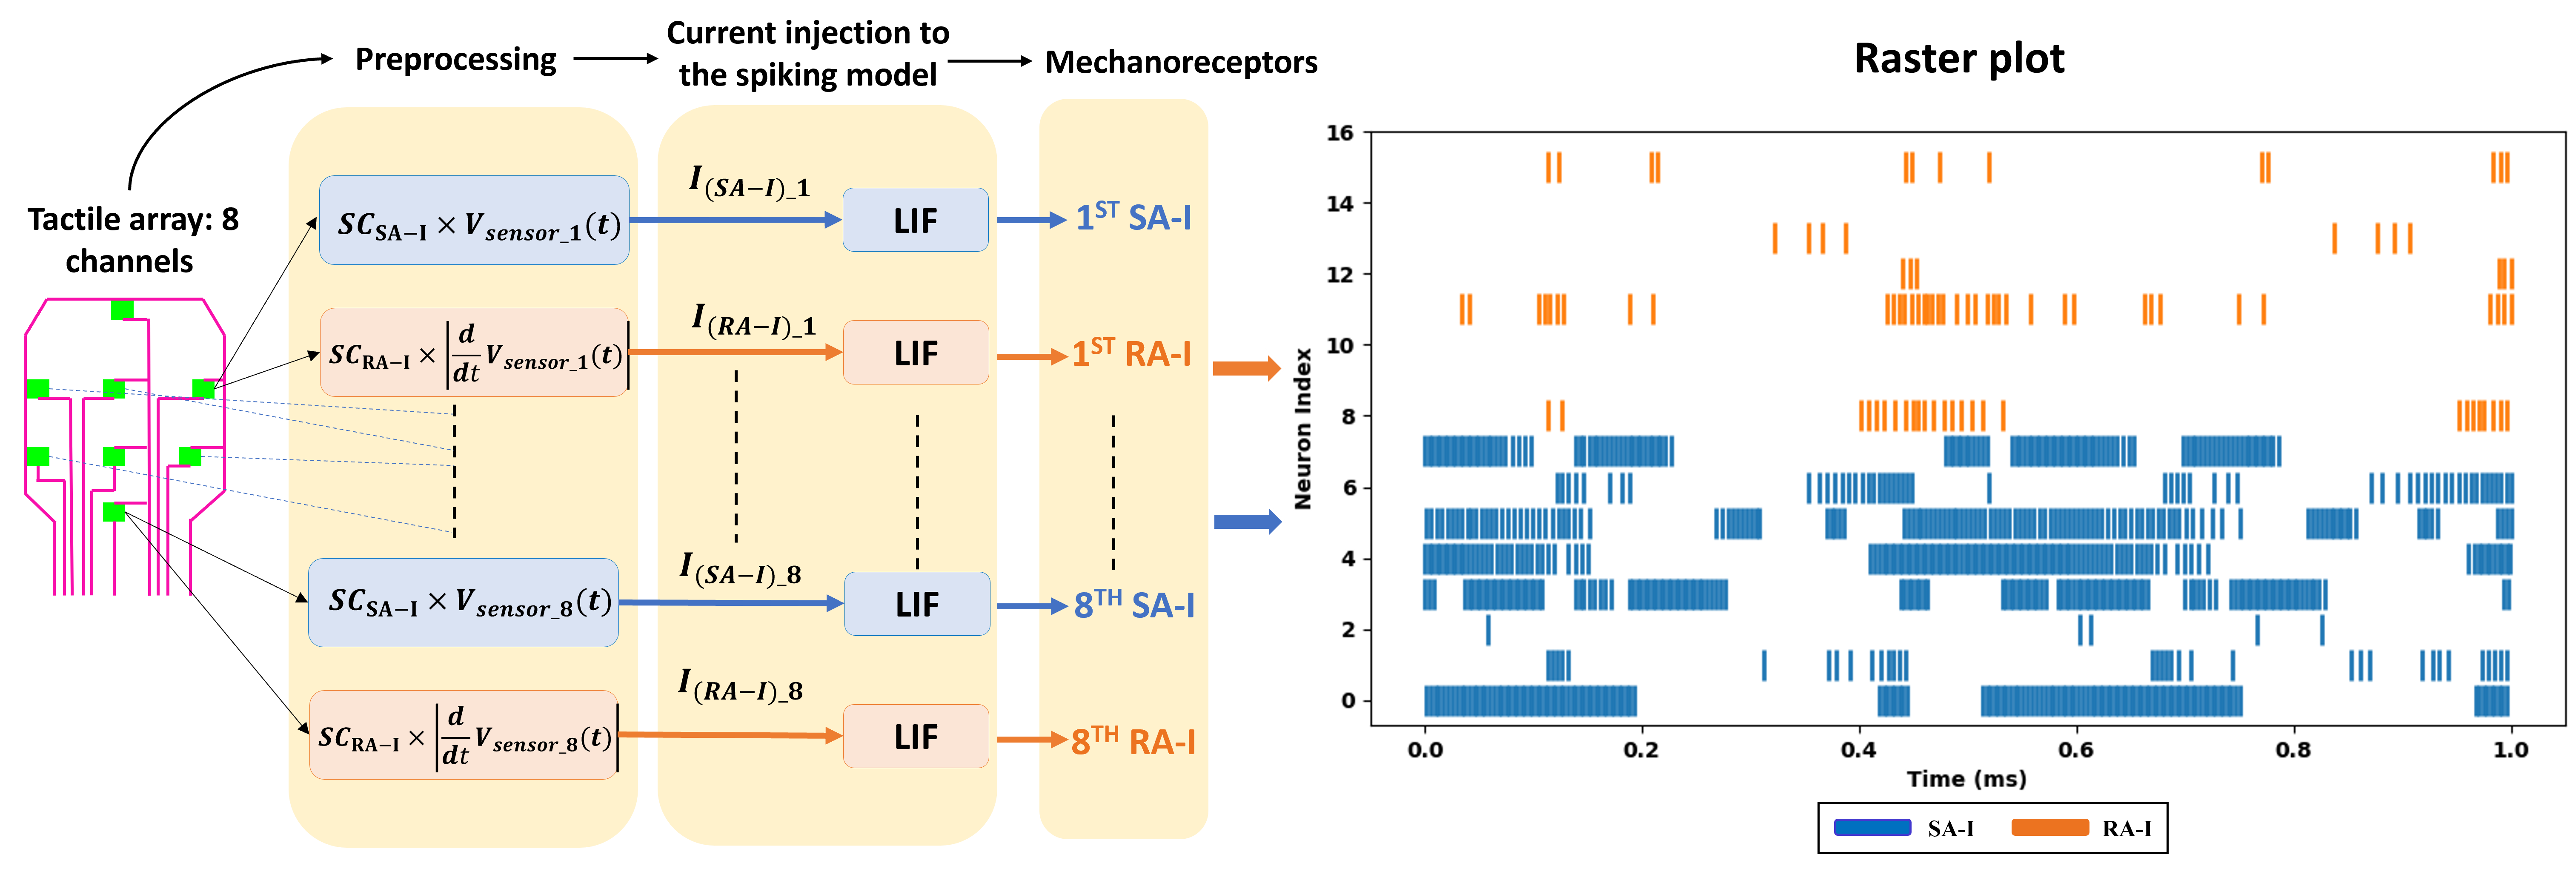

**Install the required libraries**

In [1]:
! pip install brian2
from brian2 import *
import numpy as np
import glob

**Data will be published soon**

In [2]:
!unzip /content/data.zip -d /content

Archive:  /content/data.zip
replace /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text1/Texture_Text1_Sp400_Dr(x)_Fr168_t3.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text5/Texture_Text5_Sp400_Dr(x)_Fr168_t30.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t1.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t2.txt  
  inflating: /content/data/Text8/Texture_Text8_Sp400_Dr(x)_Fr168_t30.txt  


In [3]:
import pandas as pd

**Read the .txt files of the tactile signals, in this example we consider only "Grating 1": roughest texture**


We removed the first 3000 timestamps from the data collection due to mechanical noise originating from the Cartesian robot.


In [4]:
data_path = '/content/data/Text1'
signals = glob.glob(data_path+ '/*')
li = []
for i in signals:
    sig = pd.read_csv(i,sep='\t',skiprows=3000)
    sig = sig.iloc[:2000] ### We used only 1 second of tactile signal (sampling frequency:2k/s)
    sig = np.array(sig)
    sig = sig - mean(sig, axis=0) ###remove the dc offset of the tactile sensors
    li.append(sig)

**Function: Encoding Block**

In [5]:
#The arguments are:
#Li: input signals to be encoded.
# SC1 = Scaling factor of SA-I mechanoreceptors.
# SC2 = Scaling factor of RA-I mechanoreceptors.
# SA_t_ref = refractory period value of SA-I.
# RA_t_ref = refractory period value of RA-I.
# thr = spiking threshold of the LIF neuron.
# reset = resting voltage after spike emission.
# tau = time decay of the voltage membrane of the LIF neuron.
def encoding(li,SC1 = 1* Mohm,SC2 = 1* Mohm,SA_t_ref = 1 *ms,RA_t_ref=1 *ms ,thr= 'v>-55*mV',reset = 'v = -65*mV',tau =10 *ms):
  spk = []
  spike_monitor_SA = []
  spike_monitor_RA = []
  state_monitor_SA = []
  state_monitor_RA = []
  for ii in li:
    I_recorder_SA = TimedArray((ii) * nA, dt=1 * ms)##Input current for SA-I mechanoreceptor
    iii2 = abs(np.diff(ii, axis=0))                    ###signal preprocssing to convert it to suitable input current for RA-I mechanoreceptor. The preprocessing is based on absolute value of the signal derivative
    I_recorder_RA = TimedArray((iii2) * nA, dt=1 * ms)   ##Input current for RA-I mechanoreceptor
    tau = tau ;
    E1 = -70 * mV;
    defaultclock.dt = 1 * ms;
    SC1 = SC1;
    SC2 = SC2;

    eqs1 = '''  dv/dt = ((E1-v)+SC1*I_recorder_SA(t,i))/tau : volt (unless refractory)
    '''##LIF equation for SA-I
    eqs2 = '''  dv/dt = ((E1-v)+SC2*I_recorder_RA(t,i))/tau : volt (unless refractory)
    '''##LIF equation for RA-I
    group1 = NeuronGroup(8, eqs1, threshold= thr, reset= reset, refractory= SA_t_ref , method='exact') ##Building group of 8 SA-I mechanoreceptors with refractory period = SA_t_ref
    group1.v = -65 * mV

    group2 = NeuronGroup(8, eqs2, threshold=thr, reset=reset, refractory= RA_t_ref,  method='exact')##Building group of 8 RA-I mechanoreceptors with refractory period = RA_t_ref
    group2.v = -65* mV

    S1_SA = SpikeMonitor(group1)
    S2_RA = SpikeMonitor(group2)

    spike_monitor_SA.append(S1_SA)
    spike_monitor_RA.append(S2_RA)

    Sv_SA = StateMonitor(group1, 'v', record = True)
    Sv_RA =StateMonitor(group2, 'v', record = True)

    state_monitor_SA.append(Sv_SA)
    state_monitor_RA.append(Sv_RA)

    run(len(ii) * 1 * ms)

    spike_times1 = S1_SA.spike_trains()###extract the timing of the spikes of the 8 SA-I
    spike_times2 = S2_RA.spike_trains()###extract the timing of the spikes of the 8 RA-I

    ##Convert the timing of the spikes into a binary array called "concatenated_array"
    dt = 1 * ms
    spikes_binary1 = np.zeros((int(len(ii.T) * 1 * ms / dt), len(ii)))
    spikes_binary2 = np.zeros((int(len(ii.T) * 1 * ms / dt), len(ii)))
    for c in range(len(spike_times1)):
        x1 = spike_times1[c]
        x2 = spike_times2[c]
        int_x1 = np.asarray(x1 / dt, dtype='int')
        int_x2 = np.asarray(x2 / dt, dtype='int')
        for j in int_x1:
            spikes_binary1[c][j] = 1
            spikes_binary2[c][j] = 1
            concatenated_array = np.vstack((spikes_binary1, spikes_binary2))
            spk.append(concatenated_array.T) ###spk list saves the spikes of the 8 SA-I and 8 RA-I receptors
  return spk,spike_monitor_SA,spike_monitor_RA,state_monitor_SA,state_monitor_RA

**Example of encoding using refractory period of 1 ms**

In [6]:
SA_t_ref = 1*ms # 5, 10  ###Change the value of refractory period manually
RA_t_ref = 1*ms # 5, 10  ###Change the value of refractory period manually
SC1 = 6400* Mohm
SC2 = 12000* Mohm
tau = 10*ms
reset = 'v = -65*mV'
threshold =  'v>-55*mV'

In [7]:
spk,S1_SA,S2_RA,Sv_SA,Sv_RA = encoding(li,SC1,SC2,SA_t_ref,RA_t_ref,threshold,reset,tau)

**Demonstarte the size of the spk list**

In [8]:
print(spk[0].shape)
print(spk[0])

(2000, 16)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The SA-I mechanoreceptors exhibit higher firing rate than RA-I. By comouting the firing rate it will be more clear

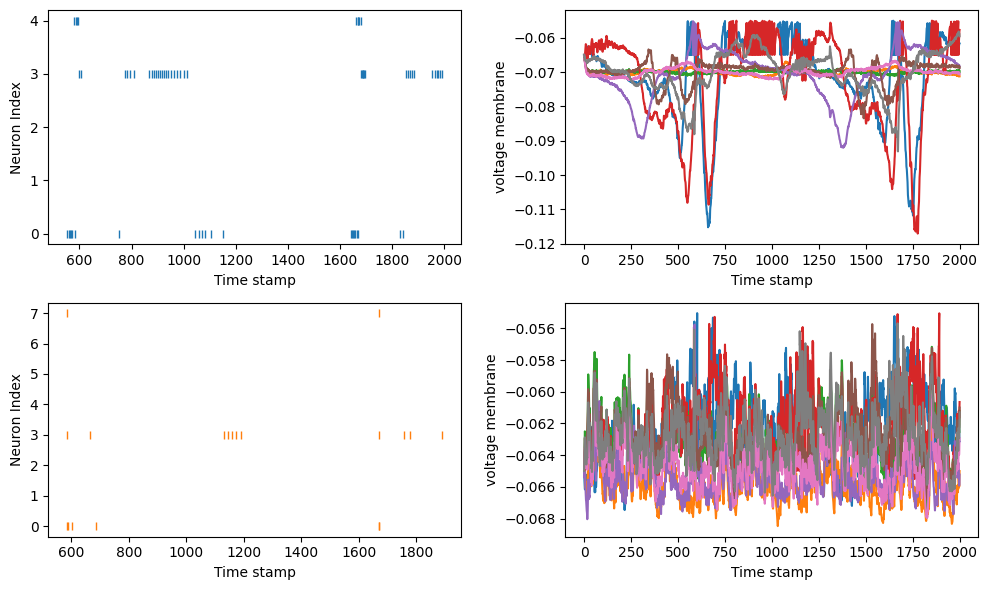

In [9]:
plt.figure(figsize=(10, 6))
subplot(221)
plot(S1_SA[0].t/ms, S1_SA[0].i,'|', color = 'C0') ###raster plot of the 8 SA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')
subplot(222)
plot(Sv_RA[0].t/ms, Sv_SA[0].v[:].T)###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('voltage membrane')
subplot(223)
plot(S2_RA[0].t/ms, S2_RA[0].i,'|', color = 'C1')###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')
subplot(224)
plot(Sv_RA[0].t/ms, Sv_RA[0].v[:].T)###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('voltage membrane')

# Fit the plots within the subplots
tight_layout()


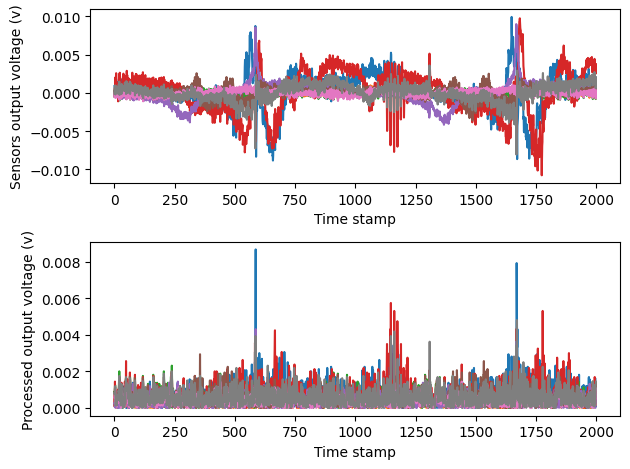

In [10]:
plt.subplot(211)
plt.plot(li[0])
plt.xlabel('Time stamp')  # The time axis can be normalized between 0 and 1 second
plt.ylabel('Sensors output voltage (v)')


plt.subplot(212)
plt.plot(abs(np.diff(li[0], axis=0)))
plt.xlabel('Time stamp')  # The time axis can be normalized between 0 and 1 second
plt.ylabel('Processed output voltage (v)')
plt.tight_layout()  # Plot the absolute derivative of the tactile signal (corresponds to the RA-I)
plt.show()

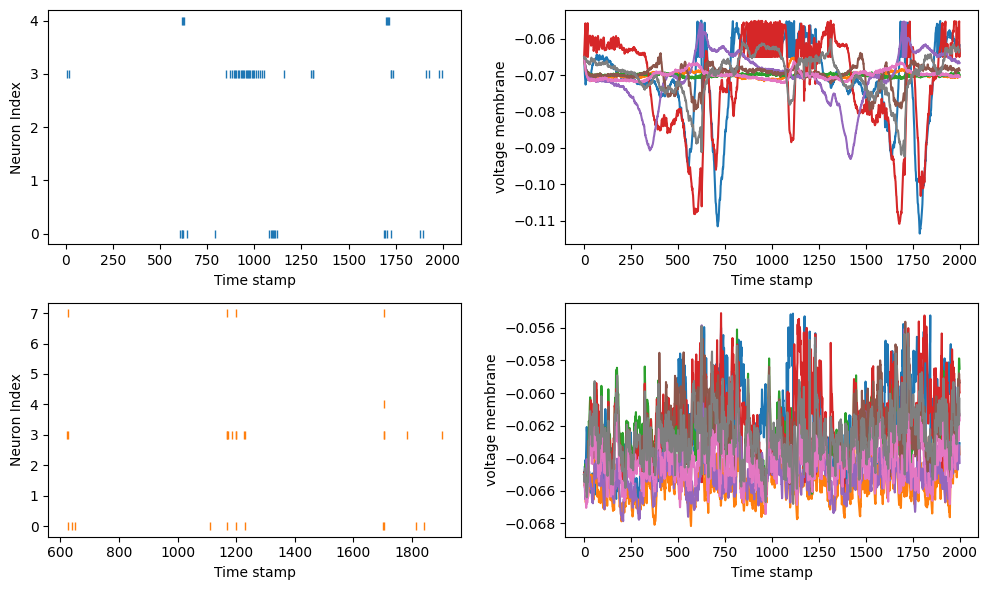

In [11]:
plt.figure(figsize=(10, 6))
subplot(221)
plot(S1_SA[1].t/ms, S1_SA[1].i,'|', color = 'C0') ###raster plot of the 8 SA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')
subplot(222)
plot(Sv_RA[1].t/ms, Sv_SA[1].v[:].T)###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('voltage membrane')
subplot(223)
plot(S2_RA[1].t/ms, S2_RA[1].i,'|', color = 'C1')###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('Neuron Index')
subplot(224)
plot(Sv_RA[1].t/ms, Sv_RA[1].v[:].T)###raster plot of the 8 RA-I mechanoreceptors
xlabel('Time stamp')###the time axis can be normalized between 0 and 1 second
ylabel('voltage membrane')

# Fit the plots within the subplots
tight_layout()